In [14]:
source('utilities.R')
library(tidyr)
library(ggplot2)
library(readr)
options(repr.plot.width = 10, repr.plot.height = 6)


Attachement du package : 'dplyr'


Les objets suivants sont masqués depuis 'package:stats':

    filter, lag


Les objets suivants sont masqués depuis 'package:base':

    intersect, setdiff, setequal, union



Attachement du package : 'lubridate'


Les objets suivants sont masqués depuis 'package:base':

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.


Attachement du package : 'purrr'


L'objet suivant est masqué depuis 'package:mclust':

    map


Le chargement a nécessité le package : future

Le chargement a nécessité le package : nlme


Attachement du package : 'nlme'


L'objet suivant est masqué depuis 'package:forecast':

    getResponse


L'objet suivant est masqué depuis 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


Attachement du package :

In [ ]:
tz <- "US/Pacific"
refit_starts <- as.Date('2019-01-07',tz=tz)
refit_ends <- as.Date('2019-11-10',tz=tz)
horizon <- 14
step = 15

### 0. Load Models

In [6]:
# No weather 
use_weather <- FALSE
weather_ <- ifelse(use_weather, 'with_weather_', 'without_weather_')
no_weather_models <- readRDS(paste0('models/direct_models_', weather_, as.character(refit_ends),'.rds'))

In [17]:
# With weather 
use_weather <- TRUE
weather_ <- ifelse(use_weather, 'with_weather_', 'without_weather_')
weather_models <- readRDS(paste0('models/direct_models_', weather_, as.character(refit_ends),'.rds'))

### 1. Test data preparation

In [18]:
df <- read.csv("../Data/palo_alto.csv")

In [19]:
test_trans <- transactions(df = df, train_starts = refit_ends + 1, train_ends = refit_ends + horizon, tz = tz)

In [20]:
# with weather 
test_profile <- load_profile(test_trans,step,tz=tz)
use_weather = TRUE
if(use_weather){
    meteo_data <- get_meteo_data('../Data/weather.rds')
    test_profile <- test_profile %>% add_meteo_data(meteo_data)  
}
test_dataframe_weather <- test_profile %>% add_variables_to_profile(step = step)

Warning message:
"Using `all_of()` outside of a selecting function was deprecated in tidyselect
1.2.0.
ℹ See details at
  <https://tidyselect.r-lib.org/reference/faq-selection-context.html>"


In [11]:
# without weather 
test_profile <- load_profile(test_trans,step,tz=tz)
use_weather = FALSE
if(use_weather){
    meteo_data <- get_meteo_data('../Data/weather.rds')
    test_profile <- test_profile %>% add_meteo_data(meteo_data)  
}
test_dataframe_no_weather <- test_profile %>% add_variables_to_profile(step = step)

### 2. Forecasts

#### GAM

In [21]:
# results_gam_no_weather <- direct_model_predict(test_dataframe_no_weather, method = 'GAM', model = no_weather_models[['GAM']])
results_gam_weather <- direct_model_predict(test_dataframe_weather, method = 'GAM', model = weather_models[['GAM']])

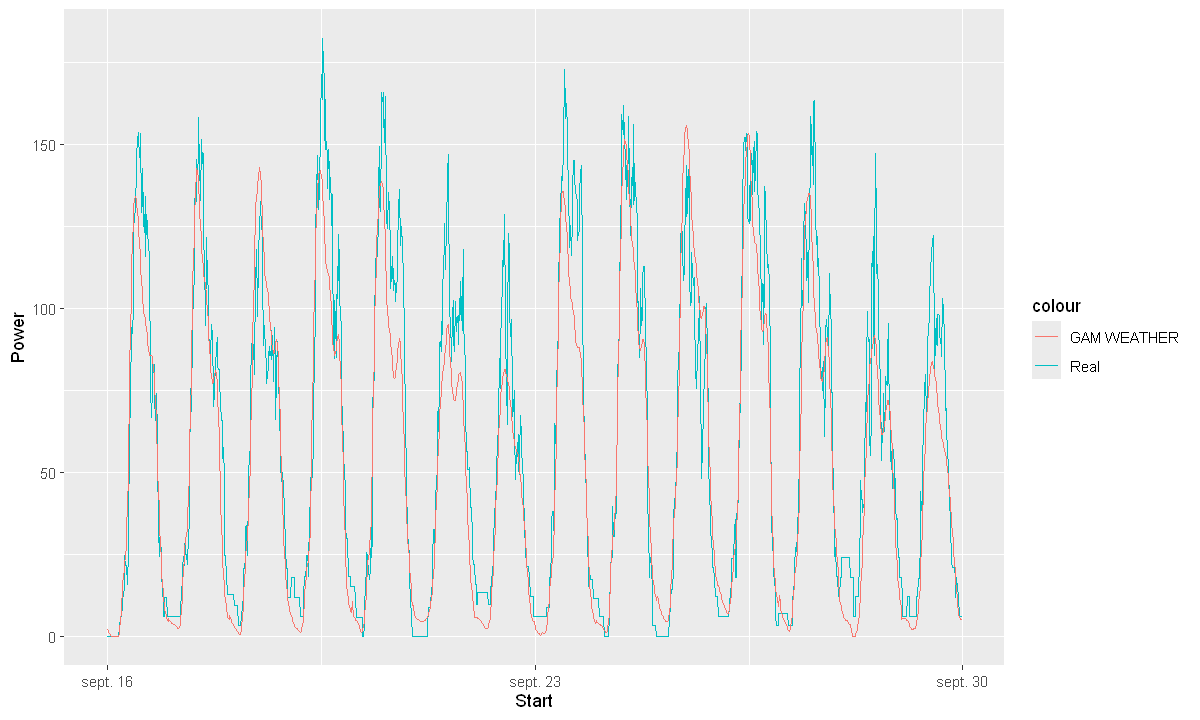

In [24]:
ggplot()+
geom_line(data = results_gam_weather, aes(Start, Power, color='Real'))+
# geom_line(data = results_gam_no_weather, aes(Start, Mean, color='GAM NO WEATHER'))+
geom_line(data = results_gam_weather, aes(Start, Mean, color='GAM WEATHER'))

In [25]:
# rmse(results_gam_no_weather$Power, results_gam_no_weather$Mean)
rmse(results_gam_weather$Power, results_gam_weather$Mean)

[1] 17.2232

#### QGAM

In [26]:
# results_qgam_no_weather <- direct_model_predict(test_dataframe_no_weather, method = 'QGAM', model = no_weather_models[['QGAM']])
results_qgam_weather <- direct_model_predict(test_dataframe_weather, method = 'QGAM', model = weather_models[['QGAM']])

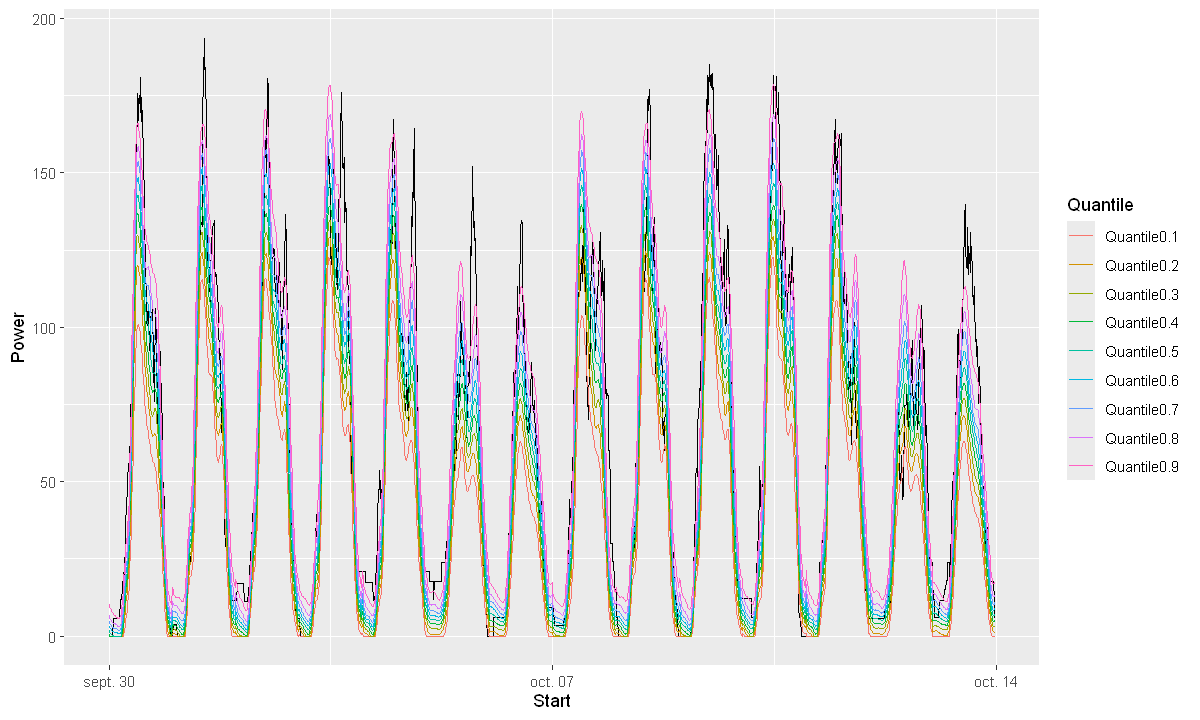

In [16]:
results_qgam_no_weather %>% gather(starts_with('Quantile'), key='Quantile', value='Prev') %>% ggplot()+
geom_line(aes(Start, Power))+
geom_line(aes(Start, Prev, color=Quantile))

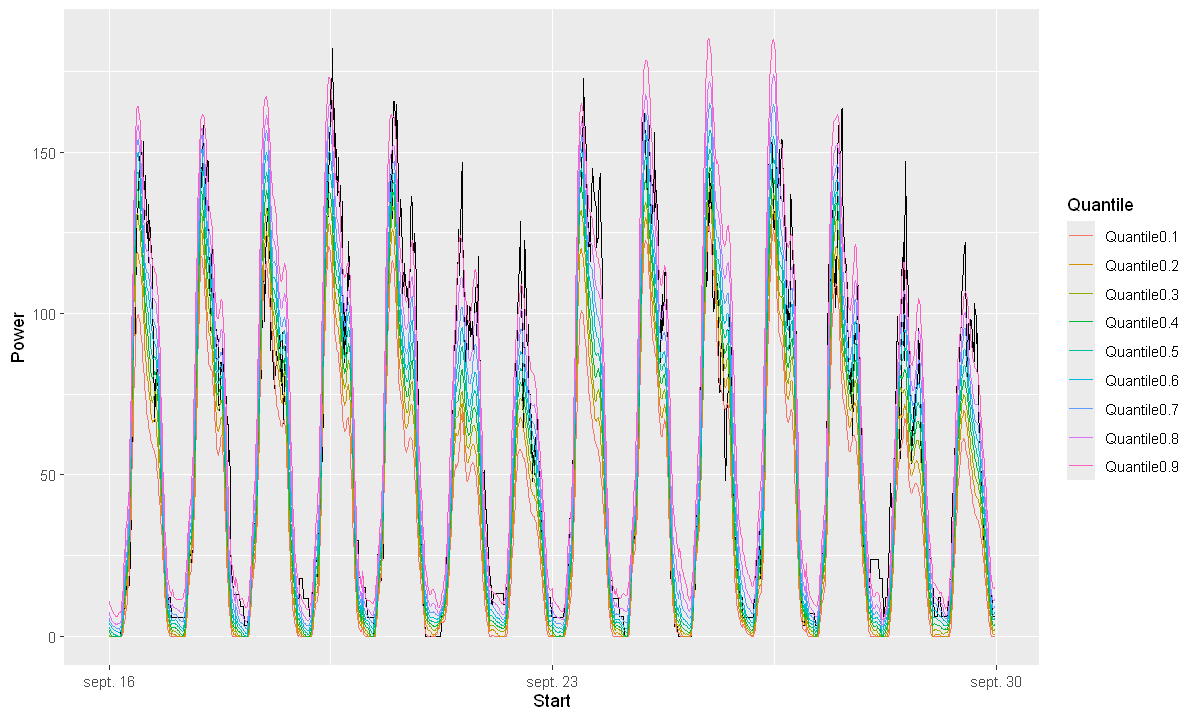

In [27]:
results_qgam_weather %>% gather(starts_with('Quantile'), key='Quantile', value='Prev') %>% ggplot()+
geom_line(aes(Start, Power))+
geom_line(aes(Start, Prev, color=Quantile))

#### GAMlss

In [28]:
# results_gamlss_no_weather <- direct_model_predict(test_dataframe_no_weather, method = 'GAMlss', model = no_weather_models[['GAMlss']])
results_gamlss_weather <- direct_model_predict(test_dataframe_weather, method = 'GAMlss', model = weather_models[['GAMlss']])

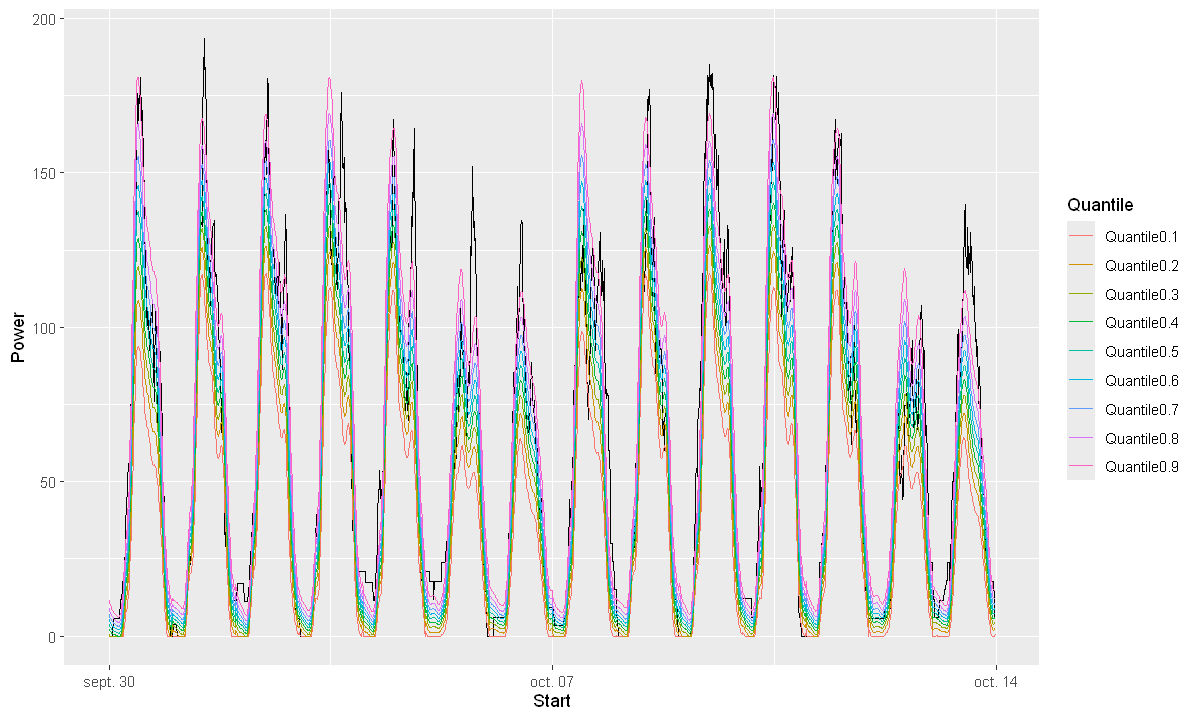

In [19]:
results_gamlss_no_weather %>% gather(starts_with('Quantile'), key='Quantile', value='Prev') %>% ggplot()+
geom_line(aes(Start, Power))+
geom_line(aes(Start, Prev, color=Quantile))

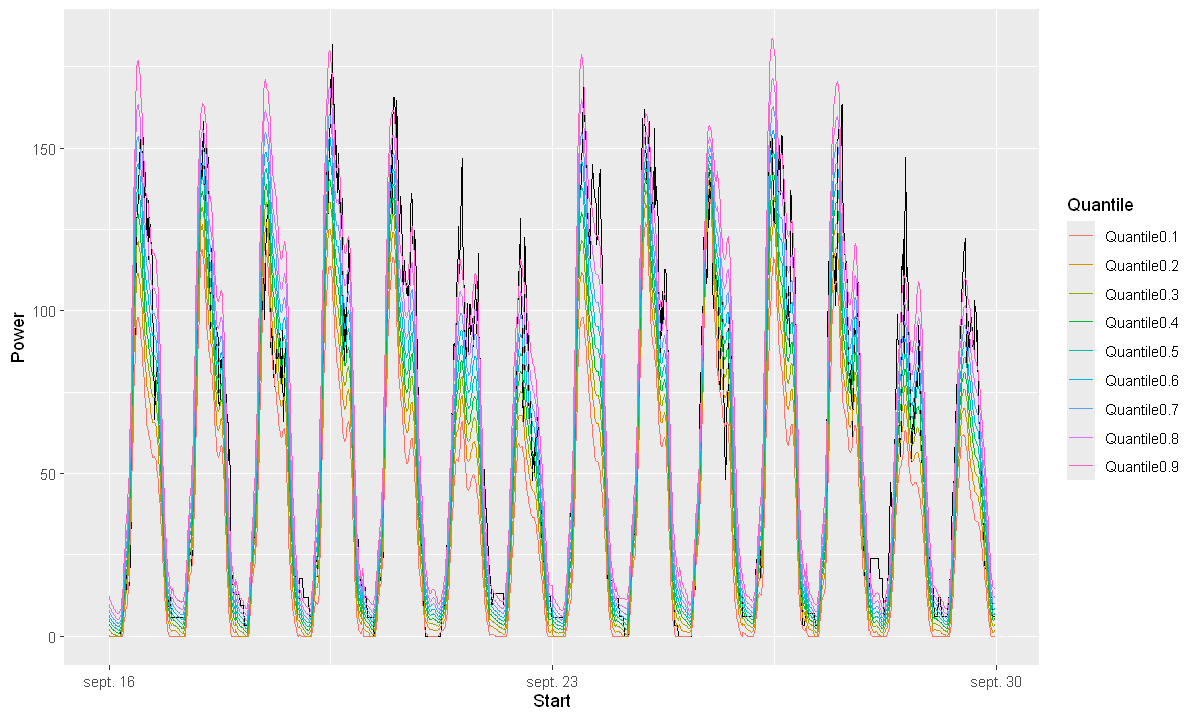

In [29]:
results_gamlss_weather %>% gather(starts_with('Quantile'), key='Quantile', value='Prev') %>% ggplot()+
geom_line(aes(Start, Power))+
geom_line(aes(Start, Prev, color=Quantile))